In [1]:
import os
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
# from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from torchvision.transforms import v2

import models as M
import trainer as T

from torch.utils.tensorboard import SummaryWriter

from plot_lib import set_default


In [2]:
set_default()

In [3]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    # else "mps"
    # if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [4]:
DATADIR = "/Users/mghifary/Work/Code/AI/data"
MODEL_DIR = "models"
# MODEL_SUFFIX = "convnet-exp2"
# MODEL_SUFFIX = "mlp-bn-exp1"
# MODEL_SUFFIX = "mlp3-bn-randaug-exp1"
# MODEL_SUFFIX = "convnet-randaug-exp1"
MODEL_SUFFIX = "convnet-exp3"
BATCH_SIZE = 128
EPOCHS = 50

In [5]:
# set tensorboard "log_dir" to "logs"
writer = SummaryWriter(f"logs/fashion-mnist_{MODEL_SUFFIX}")

In [6]:
train_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        # v2.RandAugment(),
    ]
)

inference_transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

# Download training data from open datasets.
train_data = datasets.FashionMNIST(
    root=DATADIR,
    train=True,
    download=True,
    transform=train_transform,
)

test_data = datasets.FashionMNIST(
    root=DATADIR,
    train=False,
    download=True,
    transform=inference_transform,
)

In [7]:
# Create data loaders
train_dataloader = DataLoader(
    train_data, 
    batch_size=BATCH_SIZE,
    shuffle=True,
)
test_dataloader = DataLoader(
    test_data, 
    batch_size=BATCH_SIZE,
    shuffle=False,
)

for X, y in train_dataloader:
    [_, c, dx1, dx2] = X.shape
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape}, {y.dtype}")
    break

num_classes = len(torch.unique(train_data.train_labels))

Shape of X [N, C, H, W]: torch.Size([128, 1, 28, 28])
Shape of y: torch.Size([128]), torch.int64


/opt/homebrew/lib/python3.11/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


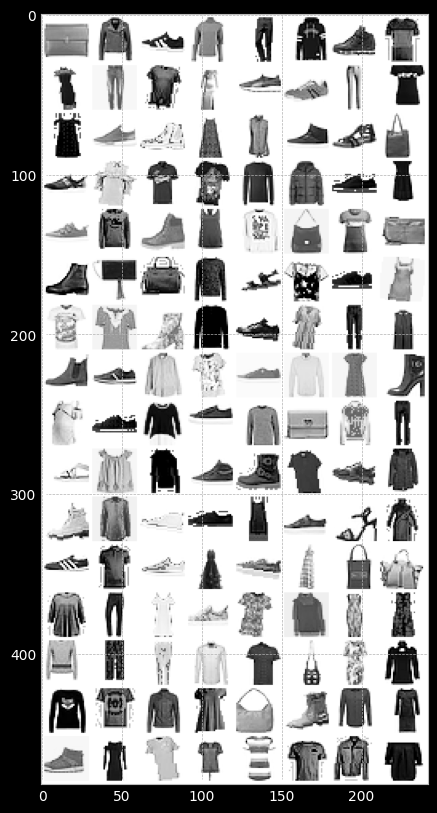

In [8]:
# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# create grid of images
img_grid = torchvision.utils.make_grid(images)

        
# show images
matplotlib_imshow(img_grid, one_channel=True)

In [9]:
# write to tensorboard
writer.add_image("fashion_mnist_images", img_grid)

In [10]:
# Initialize model
# model = M.NeuralNetwork(c, dx1, dx2, num_classes, with_bn=True)
# model = M.ResNet(1, 18, M.ResidualBlock, num_classes=num_classes)
# model = M.TinyResnet(c, M.ResidualBlock, num_classes=num_classes)
# model = M.TinyResnetV2(c, M.ResidualBlock, num_classes=num_classes)
model = M.ConvNet(c, dx1, dx2, num_classes=num_classes)
# model = M.MLP(c, dx1, dx2, 512, num_classes)
model = model.to(device)
print(model)

ConvNet(
  (convnet): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=3136, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [11]:
# Optimizer and loss function
loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [12]:
# Inspect model using Tensorboard
writer.add_graph(model, images)

In [13]:
checkpoint_dir = os.path.join(MODEL_DIR, "fashion-mnist")

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

checkpoint_path = os.path.join(checkpoint_dir, f"{MODEL_SUFFIX}.pth")

T.fit(
    model, 
    train_dataloader, 
    test_dataloader, 
    loss_fn, 
    optimizer, 
    n_epochs=EPOCHS, 
    checkpoint_path=checkpoint_path, 
    writer=writer
)
 
print("Done!")

Epoch 1
-------------------------------


100%|██████████| 469/469 [00:29<00:00, 15.77batch/s, loss=0.56] 


Training performance:
- Accuracy: 77.36%, Avg loss: 0.6188 

Test performance:
- Accuracy: 82.19%, Avg loss: 0.4933 

Elapsed time: 29.75 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-randaug-exp1.pth
Epoch 2
-------------------------------


100%|██████████| 469/469 [00:29<00:00, 16.03batch/s, loss=0.475]


Training performance:
- Accuracy: 81.52%, Avg loss: 0.5121 

Test performance:
- Accuracy: 85.49%, Avg loss: 0.4159 

Elapsed time: 29.26 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-randaug-exp1.pth
Epoch 3
-------------------------------


100%|██████████| 469/469 [00:29<00:00, 16.17batch/s, loss=0.477]


Training performance:
- Accuracy: 82.67%, Avg loss: 0.4777 

Test performance:
- Accuracy: 86.10%, Avg loss: 0.3910 

Elapsed time: 29.01 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-randaug-exp1.pth
Epoch 4
-------------------------------


100%|██████████| 469/469 [00:28<00:00, 16.39batch/s, loss=0.375]


Training performance:
- Accuracy: 81.93%, Avg loss: 0.4751 

Test performance:
- Accuracy: 85.75%, Avg loss: 0.3808 

Elapsed time: 28.62 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-randaug-exp1.pth
Epoch 5
-------------------------------


100%|██████████| 469/469 [00:28<00:00, 16.40batch/s, loss=0.401]


Training performance:
- Accuracy: 85.18%, Avg loss: 0.4076 

Test performance:
- Accuracy: 88.13%, Avg loss: 0.3347 

Elapsed time: 28.60 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-randaug-exp1.pth
Epoch 6
-------------------------------


100%|██████████| 469/469 [00:28<00:00, 16.35batch/s, loss=0.345]


Training performance:
- Accuracy: 85.36%, Avg loss: 0.3969 

Test performance:
- Accuracy: 88.27%, Avg loss: 0.3271 

Elapsed time: 28.68 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-randaug-exp1.pth
Epoch 7
-------------------------------


100%|██████████| 469/469 [00:28<00:00, 16.37batch/s, loss=0.283]


Training performance:
- Accuracy: 85.55%, Avg loss: 0.3905 

Test performance:
- Accuracy: 88.43%, Avg loss: 0.3171 

Elapsed time: 28.65 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-randaug-exp1.pth
Epoch 8
-------------------------------


100%|██████████| 469/469 [00:28<00:00, 16.28batch/s, loss=0.262]


Training performance:
- Accuracy: 86.23%, Avg loss: 0.3775 

Test performance:
- Accuracy: 88.73%, Avg loss: 0.3177 

Elapsed time: 28.82 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-randaug-exp1.pth
Epoch 9
-------------------------------


100%|██████████| 469/469 [00:28<00:00, 16.32batch/s, loss=0.438]


Training performance:
- Accuracy: 86.88%, Avg loss: 0.3582 

Test performance:
- Accuracy: 89.45%, Avg loss: 0.2996 

Elapsed time: 28.73 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-randaug-exp1.pth
Epoch 10
-------------------------------


100%|██████████| 469/469 [00:28<00:00, 16.30batch/s, loss=0.271]


Training performance:
- Accuracy: 86.98%, Avg loss: 0.3492 

Test performance:
- Accuracy: 89.30%, Avg loss: 0.2997 

Elapsed time: 28.77 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-randaug-exp1.pth
Epoch 11
-------------------------------


100%|██████████| 469/469 [00:28<00:00, 16.28batch/s, loss=0.354]


Training performance:
- Accuracy: 87.81%, Avg loss: 0.3356 

Test performance:
- Accuracy: 89.86%, Avg loss: 0.2821 

Elapsed time: 28.82 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-randaug-exp1.pth
Epoch 12
-------------------------------


100%|██████████| 469/469 [00:29<00:00, 16.13batch/s, loss=0.429]


Training performance:
- Accuracy: 87.87%, Avg loss: 0.3296 

Test performance:
- Accuracy: 89.81%, Avg loss: 0.2829 

Elapsed time: 29.07 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-randaug-exp1.pth
Epoch 13
-------------------------------


100%|██████████| 469/469 [00:28<00:00, 16.23batch/s, loss=0.404]


Training performance:
- Accuracy: 87.85%, Avg loss: 0.3297 

Test performance:
- Accuracy: 89.89%, Avg loss: 0.2775 

Elapsed time: 28.90 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-randaug-exp1.pth
Epoch 14
-------------------------------


100%|██████████| 469/469 [00:29<00:00, 16.15batch/s, loss=0.567]


Training performance:
- Accuracy: 88.24%, Avg loss: 0.3182 

Test performance:
- Accuracy: 90.16%, Avg loss: 0.2741 

Elapsed time: 29.04 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-randaug-exp1.pth
Epoch 15
-------------------------------


100%|██████████| 469/469 [00:28<00:00, 16.23batch/s, loss=0.39] 


Training performance:
- Accuracy: 88.23%, Avg loss: 0.3171 

Test performance:
- Accuracy: 90.24%, Avg loss: 0.2710 

Elapsed time: 28.90 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-randaug-exp1.pth
Epoch 16
-------------------------------


100%|██████████| 469/469 [00:28<00:00, 16.20batch/s, loss=0.409]


Training performance:
- Accuracy: 88.47%, Avg loss: 0.3102 

Test performance:
- Accuracy: 90.27%, Avg loss: 0.2702 

Elapsed time: 28.95 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-randaug-exp1.pth
Epoch 17
-------------------------------


100%|██████████| 469/469 [00:28<00:00, 16.31batch/s, loss=0.458]


Training performance:
- Accuracy: 89.03%, Avg loss: 0.3013 

Test performance:
- Accuracy: 90.39%, Avg loss: 0.2690 

Elapsed time: 28.76 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-randaug-exp1.pth
Epoch 18
-------------------------------


100%|██████████| 469/469 [00:29<00:00, 16.15batch/s, loss=0.332]


Training performance:
- Accuracy: 88.79%, Avg loss: 0.3019 

Test performance:
- Accuracy: 90.65%, Avg loss: 0.2632 

Elapsed time: 29.04 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-randaug-exp1.pth
Epoch 19
-------------------------------


100%|██████████| 469/469 [00:28<00:00, 16.31batch/s, loss=0.413]


Training performance:
- Accuracy: 89.66%, Avg loss: 0.2830 

Test performance:
- Accuracy: 90.90%, Avg loss: 0.2518 

Elapsed time: 28.76 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-randaug-exp1.pth
Epoch 20
-------------------------------


100%|██████████| 469/469 [00:28<00:00, 16.29batch/s, loss=0.283]


Training performance:
- Accuracy: 89.47%, Avg loss: 0.2846 

Test performance:
- Accuracy: 90.99%, Avg loss: 0.2481 

Elapsed time: 28.79 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-randaug-exp1.pth
Epoch 21
-------------------------------


100%|██████████| 469/469 [00:28<00:00, 16.21batch/s, loss=0.358]


Training performance:
- Accuracy: 89.40%, Avg loss: 0.2885 

Test performance:
- Accuracy: 90.89%, Avg loss: 0.2486 

Elapsed time: 28.93 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-randaug-exp1.pth
Epoch 22
-------------------------------


100%|██████████| 469/469 [00:29<00:00, 15.92batch/s, loss=0.285]


Training performance:
- Accuracy: 89.89%, Avg loss: 0.2759 

Test performance:
- Accuracy: 91.10%, Avg loss: 0.2471 

Elapsed time: 29.45 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-randaug-exp1.pth
Epoch 23
-------------------------------


100%|██████████| 469/469 [00:29<00:00, 16.15batch/s, loss=0.394]


Training performance:
- Accuracy: 89.89%, Avg loss: 0.2756 

Test performance:
- Accuracy: 90.97%, Avg loss: 0.2504 

Elapsed time: 29.03 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-randaug-exp1.pth
Epoch 24
-------------------------------


100%|██████████| 469/469 [00:29<00:00, 15.93batch/s, loss=0.315]


Training performance:
- Accuracy: 90.29%, Avg loss: 0.2668 

Test performance:
- Accuracy: 91.23%, Avg loss: 0.2385 

Elapsed time: 29.45 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-randaug-exp1.pth
Epoch 25
-------------------------------


100%|██████████| 469/469 [00:29<00:00, 16.13batch/s, loss=0.212]


Training performance:
- Accuracy: 90.47%, Avg loss: 0.2601 

Test performance:
- Accuracy: 91.44%, Avg loss: 0.2346 

Elapsed time: 29.07 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-randaug-exp1.pth
Epoch 26
-------------------------------


100%|██████████| 469/469 [00:29<00:00, 15.97batch/s, loss=0.188]


Training performance:
- Accuracy: 90.08%, Avg loss: 0.2699 

Test performance:
- Accuracy: 91.51%, Avg loss: 0.2407 

Elapsed time: 29.37 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-randaug-exp1.pth
Epoch 27
-------------------------------


100%|██████████| 469/469 [00:29<00:00, 16.05batch/s, loss=0.296]


Training performance:
- Accuracy: 90.38%, Avg loss: 0.2622 

Test performance:
- Accuracy: 91.36%, Avg loss: 0.2370 

Elapsed time: 29.22 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-randaug-exp1.pth
Epoch 28
-------------------------------


100%|██████████| 469/469 [00:29<00:00, 15.95batch/s, loss=0.285]


Training performance:
- Accuracy: 90.49%, Avg loss: 0.2570 

Test performance:
- Accuracy: 91.84%, Avg loss: 0.2315 

Elapsed time: 29.41 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-randaug-exp1.pth
Epoch 29
-------------------------------


100%|██████████| 469/469 [00:29<00:00, 15.65batch/s, loss=0.184]


Training performance:
- Accuracy: 90.89%, Avg loss: 0.2495 

Test performance:
- Accuracy: 92.14%, Avg loss: 0.2313 

Elapsed time: 29.97 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-randaug-exp1.pth
Epoch 30
-------------------------------


100%|██████████| 469/469 [00:29<00:00, 16.09batch/s, loss=0.175]


Training performance:
- Accuracy: 90.89%, Avg loss: 0.2471 

Test performance:
- Accuracy: 91.72%, Avg loss: 0.2280 

Elapsed time: 29.14 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-randaug-exp1.pth
Epoch 31
-------------------------------


100%|██████████| 469/469 [00:29<00:00, 16.15batch/s, loss=0.352]


Training performance:
- Accuracy: 90.64%, Avg loss: 0.2526 

Test performance:
- Accuracy: 91.83%, Avg loss: 0.2325 

Elapsed time: 29.04 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-randaug-exp1.pth
Epoch 32
-------------------------------


100%|██████████| 469/469 [00:29<00:00, 16.09batch/s, loss=0.304] 


Training performance:
- Accuracy: 90.16%, Avg loss: 0.2620 

Test performance:
- Accuracy: 91.30%, Avg loss: 0.2427 

Elapsed time: 29.16 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-randaug-exp1.pth
Epoch 33
-------------------------------


100%|██████████| 469/469 [00:29<00:00, 15.94batch/s, loss=0.302]


Training performance:
- Accuracy: 91.06%, Avg loss: 0.2451 

Test performance:
- Accuracy: 92.01%, Avg loss: 0.2293 

Elapsed time: 29.42 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-randaug-exp1.pth
Epoch 34
-------------------------------


100%|██████████| 469/469 [00:29<00:00, 15.72batch/s, loss=0.182]


Training performance:
- Accuracy: 91.19%, Avg loss: 0.2404 

Test performance:
- Accuracy: 91.84%, Avg loss: 0.2254 

Elapsed time: 29.84 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-randaug-exp1.pth
Epoch 35
-------------------------------


100%|██████████| 469/469 [00:29<00:00, 16.12batch/s, loss=0.135]


Training performance:
- Accuracy: 91.37%, Avg loss: 0.2342 

Test performance:
- Accuracy: 92.10%, Avg loss: 0.2237 

Elapsed time: 29.10 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-randaug-exp1.pth
Epoch 36
-------------------------------


100%|██████████| 469/469 [00:29<00:00, 15.85batch/s, loss=0.148]


Training performance:
- Accuracy: 91.62%, Avg loss: 0.2279 

Test performance:
- Accuracy: 91.91%, Avg loss: 0.2225 

Elapsed time: 29.59 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-randaug-exp1.pth
Epoch 37
-------------------------------


100%|██████████| 469/469 [00:28<00:00, 16.18batch/s, loss=0.313]


Training performance:
- Accuracy: 91.28%, Avg loss: 0.2352 

Test performance:
- Accuracy: 91.76%, Avg loss: 0.2317 

Elapsed time: 28.99 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-randaug-exp1.pth
Epoch 38
-------------------------------


100%|██████████| 469/469 [00:29<00:00, 16.07batch/s, loss=0.154]


Training performance:
- Accuracy: 91.31%, Avg loss: 0.2356 

Test performance:
- Accuracy: 91.98%, Avg loss: 0.2308 

Elapsed time: 29.19 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-randaug-exp1.pth
Epoch 39
-------------------------------


100%|██████████| 469/469 [00:28<00:00, 16.46batch/s, loss=0.219] 


Training performance:
- Accuracy: 91.54%, Avg loss: 0.2307 

Test performance:
- Accuracy: 92.25%, Avg loss: 0.2236 

Elapsed time: 28.49 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-randaug-exp1.pth
Epoch 40
-------------------------------


100%|██████████| 469/469 [00:28<00:00, 16.31batch/s, loss=0.226] 


Training performance:
- Accuracy: 91.69%, Avg loss: 0.2261 

Test performance:
- Accuracy: 92.32%, Avg loss: 0.2201 

Elapsed time: 28.75 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-randaug-exp1.pth
Epoch 41
-------------------------------


100%|██████████| 469/469 [00:28<00:00, 16.29batch/s, loss=0.299] 


Training performance:
- Accuracy: 91.64%, Avg loss: 0.2270 

Test performance:
- Accuracy: 92.37%, Avg loss: 0.2191 

Elapsed time: 28.79 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-randaug-exp1.pth
Epoch 42
-------------------------------


100%|██████████| 469/469 [00:28<00:00, 16.32batch/s, loss=0.158]


Training performance:
- Accuracy: 91.57%, Avg loss: 0.2271 

Test performance:
- Accuracy: 91.90%, Avg loss: 0.2270 

Elapsed time: 28.74 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-randaug-exp1.pth
Epoch 43
-------------------------------


100%|██████████| 469/469 [00:29<00:00, 16.17batch/s, loss=0.134]


Training performance:
- Accuracy: 91.77%, Avg loss: 0.2227 

Test performance:
- Accuracy: 92.33%, Avg loss: 0.2235 

Elapsed time: 29.01 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-randaug-exp1.pth
Epoch 44
-------------------------------


100%|██████████| 469/469 [00:29<00:00, 16.12batch/s, loss=0.192] 


Training performance:
- Accuracy: 91.98%, Avg loss: 0.2149 

Test performance:
- Accuracy: 92.45%, Avg loss: 0.2177 

Elapsed time: 29.14 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-randaug-exp1.pth
Epoch 45
-------------------------------


100%|██████████| 469/469 [00:28<00:00, 16.18batch/s, loss=0.22]  


Training performance:
- Accuracy: 91.81%, Avg loss: 0.2217 

Test performance:
- Accuracy: 92.23%, Avg loss: 0.2177 

Elapsed time: 28.98 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-randaug-exp1.pth
Epoch 46
-------------------------------


100%|██████████| 469/469 [00:28<00:00, 16.30batch/s, loss=0.318] 


Training performance:
- Accuracy: 92.36%, Avg loss: 0.2103 

Test performance:
- Accuracy: 92.71%, Avg loss: 0.2101 

Elapsed time: 28.78 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-randaug-exp1.pth
Epoch 47
-------------------------------


100%|██████████| 469/469 [00:28<00:00, 16.23batch/s, loss=0.207] 


Training performance:
- Accuracy: 92.03%, Avg loss: 0.2156 

Test performance:
- Accuracy: 92.26%, Avg loss: 0.2233 

Elapsed time: 28.90 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-randaug-exp1.pth
Epoch 48
-------------------------------


100%|██████████| 469/469 [00:28<00:00, 16.28batch/s, loss=0.28] 


Training performance:
- Accuracy: 91.37%, Avg loss: 0.2288 

Test performance:
- Accuracy: 92.01%, Avg loss: 0.2328 

Elapsed time: 28.81 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-randaug-exp1.pth
Epoch 49
-------------------------------


100%|██████████| 469/469 [00:29<00:00, 16.13batch/s, loss=0.321] 


Training performance:
- Accuracy: 92.20%, Avg loss: 0.2117 

Test performance:
- Accuracy: 92.55%, Avg loss: 0.2136 

Elapsed time: 29.08 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-randaug-exp1.pth
Epoch 50
-------------------------------


100%|██████████| 469/469 [00:29<00:00, 15.98batch/s, loss=0.142] 


Training performance:
- Accuracy: 91.75%, Avg loss: 0.2204 

Test performance:
- Accuracy: 91.99%, Avg loss: 0.2233 

Elapsed time: 29.35 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-randaug-exp1.pth
Done!


In [14]:
from torchviz import make_dot

In [15]:
pred_labels = model(images)

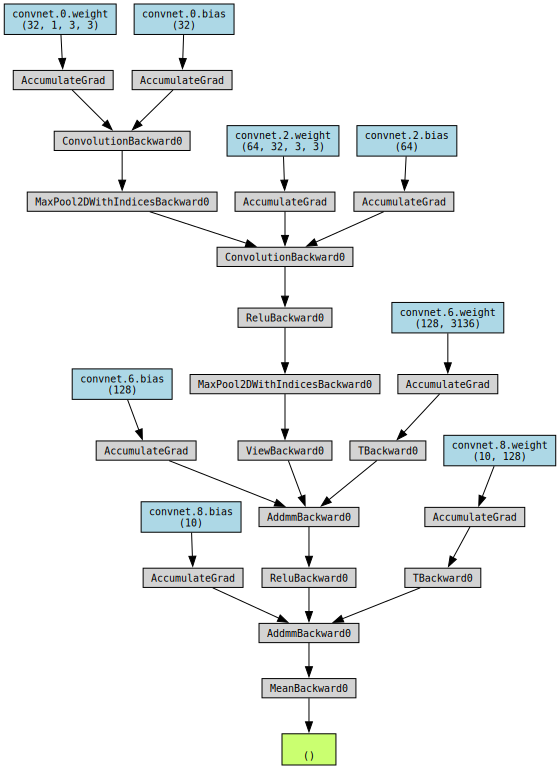

In [16]:
make_dot(pred_labels.mean(), params=dict(model.named_parameters()))